# Datasets and Dataloaders

## Dataset
- Acts as a **container** for raw data.
- Provides access to **individual samples** via indexing (`dataset[idx]`).
- Implements:
  - `__len__`: Returns the size of the dataset.
  - `__getitem__`: Fetches a single sample by index.
- Does **not handle batching**, shuffling, or parallel loading.

## Dataloader
- Wraps a `Dataset` and acts as an **iterator** for easy data loading.
- Provides **batches** of data for training or inference.
- Handles:
  - **Batching**: Combines multiple samples into batches.
  - **Shuffling**: Randomizes the order of samples.
  - **Parallel loading**: Uses multiple worker threads or processes to load data.
- Implements:
  - `__iter__`: Returns an iterator that fetches batches.
 
## Summary
| Feature              | `Dataset`                | `DataLoader`            |
|-----------------------|--------------------------|--------------------------|
| **Role**             | Data container           | Iterator for data loading |
| **Access**           | Single sample            | Batches of samples       |
| **Indexing**         | Yes (`dataset[idx]`)     | No                       |
| **Batching**         | No                       | Yes                      |
| **Shuffling**        | No                       | Yes                      |
| **Parallel Loading** | No                       | Yes                      |

## Example of a Very Simple Dataset and Dataloader

In [63]:
import numpy as np
import matplotlib.pylab as plt
import cv2 as cv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [64]:
# Step 1: Define a simple dataset
class SimpleDataset(Dataset):
    
    def __init__(self):
        # Create some dummy data (e.g., 100 samples of 2D points)
        self.inputs = torch.arange(10).view(-1, 2)  # 50 samples of [x, y] pairs
        self.targets = torch.arange(5) 
        
    def __len__(self):
        # Number of samples in the dataset
        return len(self.inputs)
    
    def __getitem__(self, idx):
        # Return a single sample at the given index
        return self.inputs[idx], self.targets[idx]

dataset = SimpleDataset()

In [65]:
batch_size = 2
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
for batch_idx, (inputs, target) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Inputs: {inputs.numpy()}")
    print(f"Target: {target.numpy()}")
    print()

Batch 1
Inputs: [[6 7]
 [4 5]]
Target: [3 2]

Batch 2
Inputs: [[0 1]
 [8 9]]
Target: [0 4]

Batch 3
Inputs: [[2 3]]
Target: [1]



## More complex example 

### Fake data creation

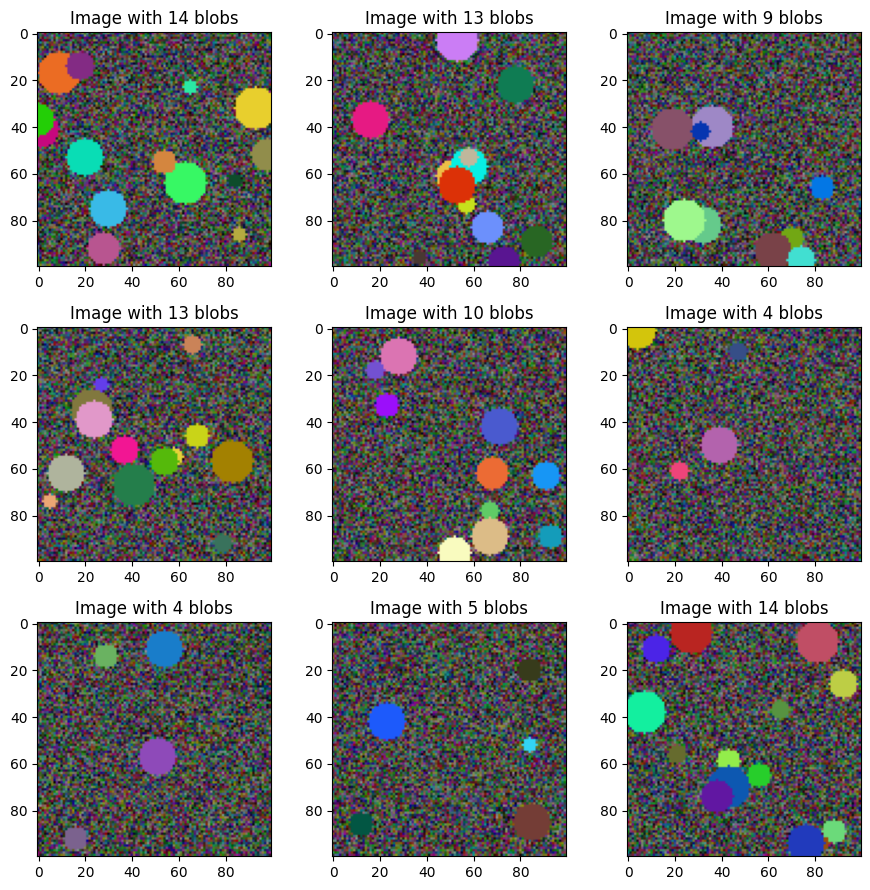

In [88]:
def generate_image_with_label():
    size = 100
    max_count = 20
    img = np.random.randint(0, 150, (size, size, 3), dtype="uint8")
    number = np.random.randint(0, max_count)
    centers = np.random.randint(0, size, (number, 2))
    radii = np.random.randint(3, 10, number)
    colors = np.random.randint(0, 255, (number, 3), dtype="int")
    for center, radius, color in zip(centers, radii, colors):
        cv.circle(img, center, radius, list(map(int, color)), -1)
    return img, number

plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(rows):
    for j in range(cols):
        plt.subplot(rows, cols, i * cols + j + 1)
        img, label = generate_image_with_label()
        plt.imshow(img)
        plt.title(f"Image with {label} blobs")
plt.tight_layout()
plt.show()

### Dataset Creation and Inspection

In [120]:
class BlobDataset(Dataset):
    
    def __init__(self, data, labels):
        self.inputs = [self._prepare_image(img) for img in data]
        self.targets = [torch.tensor(y).float() for y in labels]

    def _prepare_image(self, img):
        return torch.from_numpy(img / 255).float()
    
    def __len__(self):
        # Number of samples in the dataset
        return len(self.inputs)
    
    def __getitem__(self, idx):
        # Return a single sample at the given index
        return self.inputs[idx], self.targets[idx]


In [118]:
np.random.seed(101)
data_all, labels_all = zip(*[generate_image_with_label() for idx in range(300)])
data_train, data_val, labels_train, labels_val = train_test_split(data_all, labels_all, test_size=0.2, random_state=101)

train_dataset = BlobDataset(data_train, labels_train)
val_dataset = BlobDataset(data_val, labels_val)

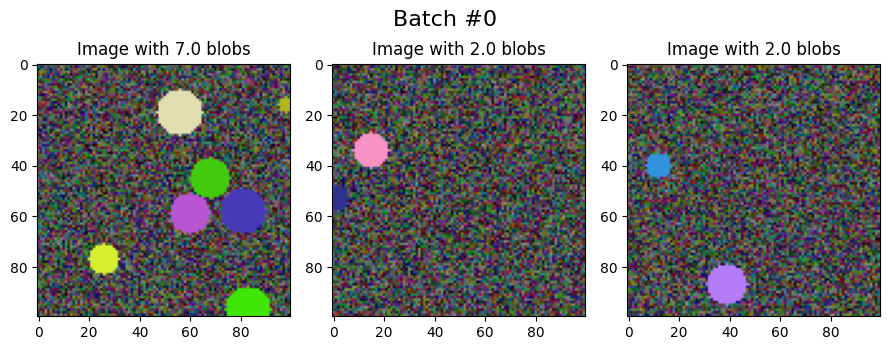

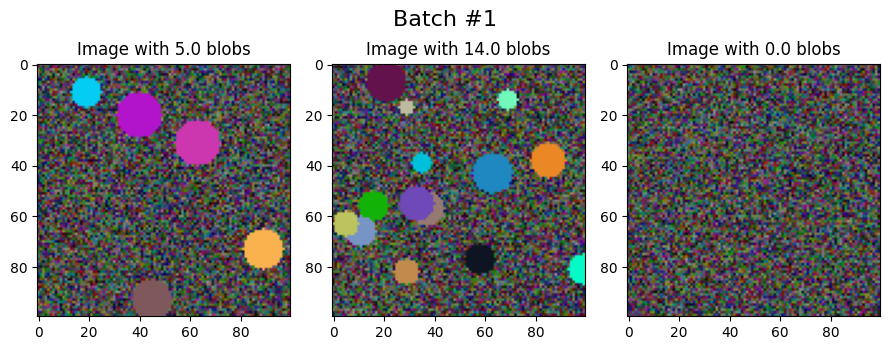

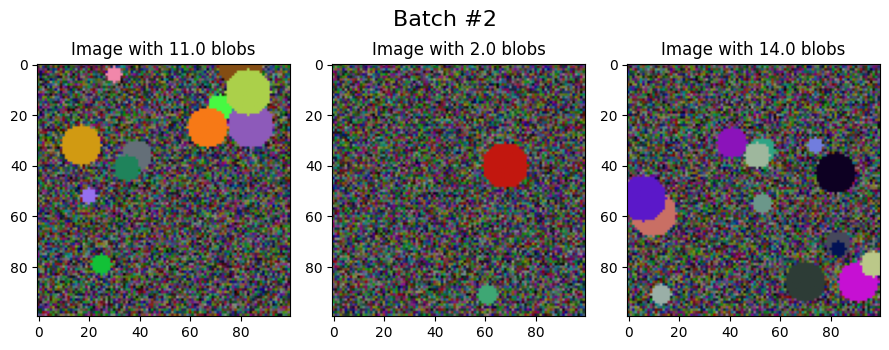

In [117]:
batch_size = 3
shuffle = False
dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
for batch_idx, (inputs, targets) in enumerate(dataloader):
    if batch_idx < 3:
        fig = plt.figure(figsize=(9, 9))
        fig.text(0.5, 0.7, f"Batch #{batch_idx}", ha='center', va='top', fontsize=16)
        for idx in range(batch_size):
            plt.subplot(1, batch_size, idx + 1)
            plt.imshow(inputs[idx])
            plt.title(f"Image with {targets[idx]} blobs")
        plt.tight_layout()
        plt.show()     

## Model and Training with Dataloader

In [106]:
class BlobCounterV1(nn.Module):
    def __init__(self):
        super(BlobCounterV1, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 3 input channels (RGB), 32 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 32 input channels, 64 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # 64 input channels, 128 output channels
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) # 128 input channels, 256 output channels
        
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)  # Average pooling layer to reduce spatial dimensions
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 6 * 6, 2048)  # Flattened output after convolution and pooling (256 channels, 12x12 spatial size)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 128)
        self.fc5 = nn.Linear(128, 1)  # Regression output for counting patches
        
        self.relu = nn.ReLU()  # ReLU activation

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # Rearranging the input to (batch_size, channels, height, width)
        
        # Apply convolution and pooling layers
        x = self.relu(self.conv1(x))  # First convolutional layer
        x = self.pool(x)  # Pooling layer
        x = self.relu(self.conv2(x))  # Second convolutional layer
        x = self.pool(x)  # Pooling layer
        x = self.relu(self.conv3(x))  # Third convolutional layer
        x = self.pool(x)  # Pooling layer
        x = self.relu(self.conv4(x))  # Fourth convolutional layer
        x = self.pool(x)  # Pooling layer

        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)  # Flatten (batch_size, 256 * 12 * 12)        

        # Pass through the fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)  # Output layer
        
        return x.squeeze(-1)  # Return scalar value as the count of patches

Epoch [0/40], Training Loss: 855.50745,  Validation Loss: 205.47635, "MAE: 8.307
Epoch [1/40], Training Loss: 896.05334,  Validation Loss: 228.65906, "MAE: 8.906
Epoch [2/40], Training Loss: 882.59753,  Validation Loss: 211.13266, "MAE: 8.455
Epoch [3/40], Training Loss: 626.27332,  Validation Loss: 70.60393, "MAE: 5.110
Epoch [4/40], Training Loss: 288.14389,  Validation Loss: 75.36427, "MAE: 5.298
Epoch [5/40], Training Loss: 270.27332,  Validation Loss: 65.77119, "MAE: 5.122
Epoch [6/40], Training Loss: 272.39865,  Validation Loss: 67.84953, "MAE: 5.082
Epoch [7/40], Training Loss: 265.74191,  Validation Loss: 71.62338, "MAE: 5.234
Epoch [8/40], Training Loss: 243.92247,  Validation Loss: 70.70311, "MAE: 5.052
Epoch [9/40], Training Loss: 254.30527,  Validation Loss: 64.02956, "MAE: 5.064
Epoch [10/40], Training Loss: 271.61365,  Validation Loss: 67.30594, "MAE: 5.142
Epoch [11/40], Training Loss: 245.13452,  Validation Loss: 62.87069, "MAE: 5.042
Epoch [12/40], Training Loss: 246.6

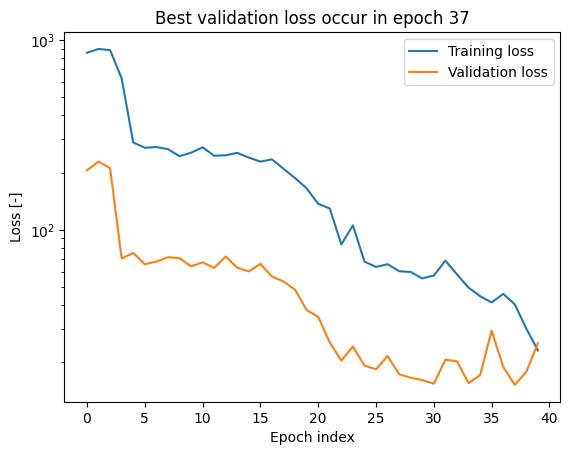

In [121]:
epochs = 40
batch_size = 32

model = BlobCounterV1()

criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.train()
    for train_inputs, train_targets in train_dataloader:
        train_outputs = model(train_inputs)
        train_loss = criterion(train_outputs, train_targets)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses[epoch] += train_loss
        
    model.eval()
    errors = []
    for val_inputs, val_targets in val_dataloader:
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        
        val_losses[epoch] += val_loss
        errors.append(np.abs(val_targets.numpy() - val_outputs.detach().numpy()))
    mae = np.concatenate(errors).mean()

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{epochs}], Training Loss: {train_losses[epoch]:.5f},  Validation Loss: {val_losses[epoch]:.5f}, "MAE: {mae:.3f}')


plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title(f"Best validation loss occur in epoch {val_losses.argmin()}")
plt.xlabel("Epoch index")
plt.ylabel("Loss [-]")
plt.yscale('log')
plt.show()

### Fake Dataset (Infinite Number of Samples)

In [119]:
class FakeBlobDataset(Dataset):
    
    def __init__(self, number):
        self.number = number

    def _prepare_image(self, img):
        return torch.from_numpy(img / 255).float()
    
    def __len__(self):
        return self.number
    
    def __getitem__(self, idx):
        img, label = generate_image_with_label()
        return self._prepare_image(img), torch.tensor(label).float()

fake_train_dataset = FakeBlobDataset(300)

Epoch [0/100], Training Loss: 989.21405,  Validation Loss: 231.26491, "MAE: 9.002
Epoch [1/100], Training Loss: 1197.29724,  Validation Loss: 228.41533, "MAE: 8.932
Epoch [2/100], Training Loss: 776.09473,  Validation Loss: 112.11223, "MAE: 6.143
Epoch [3/100], Training Loss: 517.41980,  Validation Loss: 91.62201, "MAE: 5.570
Epoch [4/100], Training Loss: 372.55777,  Validation Loss: 77.29951, "MAE: 5.220
Epoch [5/100], Training Loss: 348.11273,  Validation Loss: 70.06548, "MAE: 5.100
Epoch [6/100], Training Loss: 325.44461,  Validation Loss: 68.08215, "MAE: 5.043
Epoch [7/100], Training Loss: 325.18649,  Validation Loss: 76.72284, "MAE: 5.236
Epoch [8/100], Training Loss: 341.04431,  Validation Loss: 65.99384, "MAE: 4.965
Epoch [9/100], Training Loss: 359.86652,  Validation Loss: 64.46754, "MAE: 4.906
Epoch [10/100], Training Loss: 297.44699,  Validation Loss: 61.82665, "MAE: 4.795
Epoch [11/100], Training Loss: 302.42004,  Validation Loss: 56.95965, "MAE: 4.628
Epoch [12/100], Traini

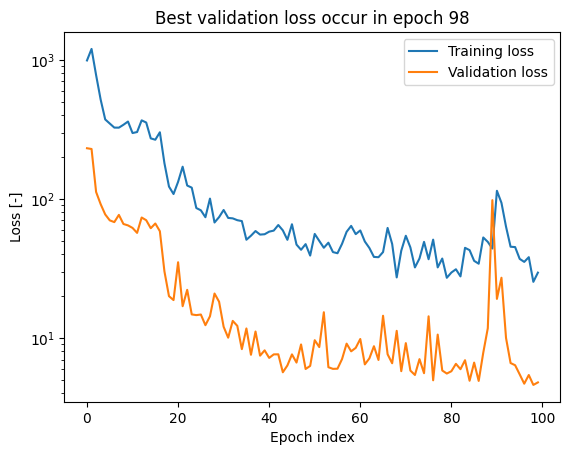

In [109]:
epochs = 100
batch_size = 32

model = BlobCounterV1()

criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

train_dataloader = DataLoader(fake_train_dataset, batch_size=batch_size, shuffle=True) # here is the Fake dataset inserted
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.train()
    for train_inputs, train_targets in train_dataloader:
        train_outputs = model(train_inputs)
        train_loss = criterion(train_outputs, train_targets)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses[epoch] += train_loss
    scheduler.step()
        
    model.eval()
    errors = []
    for val_inputs, val_targets in val_dataloader:
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        
        val_losses[epoch] += val_loss
        errors.append(np.abs(val_targets.numpy() - val_outputs.detach().numpy()))
    mae = np.concatenate(errors).mean()
        
    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{epochs}], Training Loss: {train_losses[epoch]:.5f},  Validation Loss: {val_losses[epoch]:.5f}, "MAE: {mae:.3f}')


plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title(f"Best validation loss occur in epoch {val_losses.argmin()}")
plt.xlabel("Epoch index")
plt.ylabel("Loss [-]")
plt.yscale('log')
plt.show()

## Model Evaluation with Saliency Maps

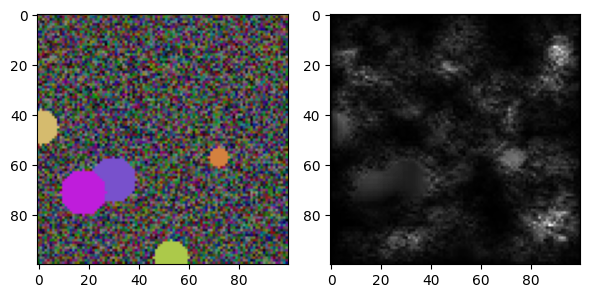

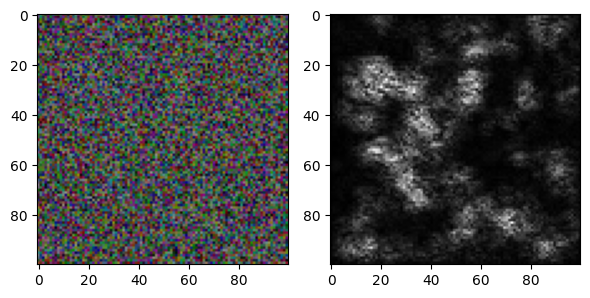

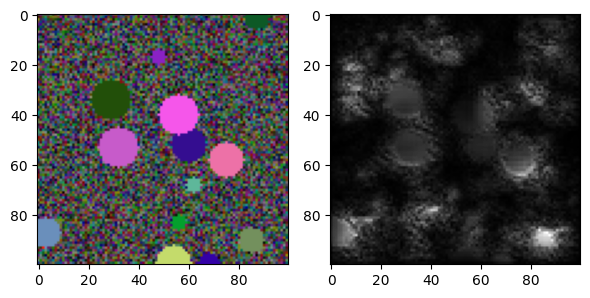

In [183]:
model.eval()

eval_dataset = FakeBlobDataset(3)

eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False)
for eval_inputs, _ in eval_dataloader:
    eval_inputs.requires_grad_()
    output = model(eval_inputs)
    output.backward()
    saliency = eval_inputs.grad.abs().squeeze(0).numpy().sum(axis=-1)
    saliency = (saliency - saliency.min()) / saliency.max() * 255
    saliency = saliency.astype("uint8")
    
    img = (eval_inputs.detach().numpy()[0] * 255).astype("uint8")
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(saliency, cmap="gray")
    plt.tight_layout()
    plt.show()